Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) = \frac{1}{2}m\omega^2x^2
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 10$, $\hbar = 1, m = 1 $ and $\omega = 1$

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

#!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [2]:
#Automatic differentiation in pytorch
def dfx(f, x):
    grads = []
    for i in range(f.shape[1]):  # iterate over columns
        grad_outputs = torch.zeros_like(f)
        grad_outputs[:, i] = 1.0
        df_i = grad(f, x, grad_outputs=grad_outputs, create_graph=True)[0]  # (n,1)
        grads.append(df_i.squeeze(-1))  # Remove extra dim to get (n,)
    return torch.stack(grads, dim=1)  # shape: (n, k)

In [3]:
#Defining the hyperparameters
t0 =-10; tf = 10; xbc = 0; eig_num = 3; 
col_pts = 200; layers = [1,100,100,eig_num]; 
lr = 1e-2; train_epochs =10000; pre_trainer_epoch = 15000


In [4]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - t0)))*(1-torch.exp(t - tf))).view(-1,1)
  psi_hat = bound + f*N1 #Broadcasting is done here
  return psi_hat

#### The In_built pretrainer

In [5]:
def fg(x, s):
    """Batch of Gaussians for different widths."""
    return torch.exp(-(x.unsqueeze(1) / s.unsqueeze(0)) ** 2)  # (n_points, n_functions)

def gauss_modulated_basis(xd, NMax):
    """Vectorized basis matrix construction."""
    n_points = xd.shape[0]
    pn = torch.arange(1, NMax+1)  # (NMax,)
    n = pn - 1  # (NMax,)

    # Build Gaussian part (n_points, NMax)
    gaussian = fg(xd, pn)

    # Build modulation polynomial part
    mfun = torch.ones((n_points, NMax))

    for idx in range(NMax):
        degree = n[idx]
        if degree > 0:
            sp = (tf-t0) / pn[idx]
            pnt = (torch.arange(1, degree+1) * sp + t0) * 0.1  # The roots 
            for pm in range(degree):
                mfun[:, idx] *= (xd - pnt[pm])

    # Multiply Gaussian × Polynomial
    basis = gaussian * mfun

    # Normalize each column
    basis = basis / basis.abs().max(dim=0, keepdim=True).values  # Normalize each basis function

    return basis

In [6]:
pnt = (torch.arange(1, 3+1) *  + t0)

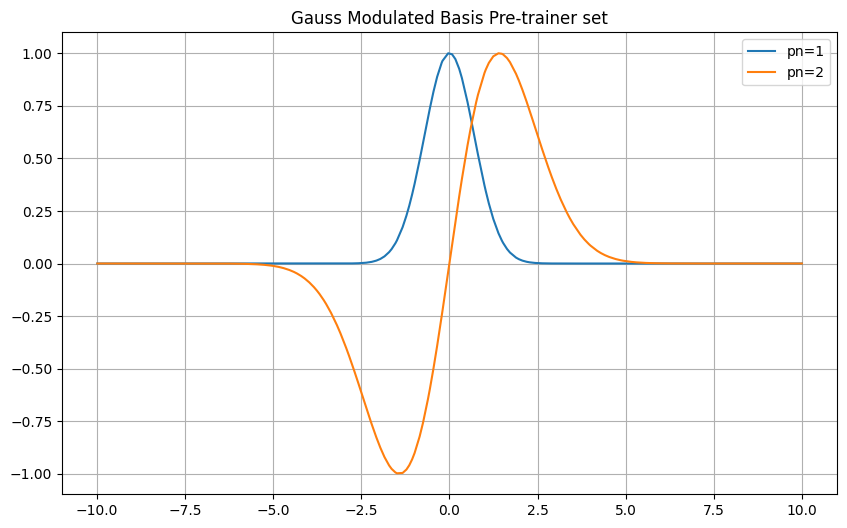

In [7]:
#Visualization

x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()

#We generate the basis using lhs, but we sort to ensure that uniformity
xlhs_sort,idx = torch.sort(x_lhs.squeeze(1))
gm_basis = gauss_modulated_basis(xlhs_sort, 2)
gm_basis_lhs = gm_basis[torch.argsort(idx), :] #To unsort i.e make the index match that of x_lhs

plt.figure(figsize=(10,6))
for i in range(2):
    plt.plot(xlhs_sort.numpy(), gm_basis[:, i].numpy(), label=f'pn={i+1}')
plt.title("Gauss Modulated Basis Pre-trainer set")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def hamEqs_Loss(t, psi, psi_xx, v):

    # Hamiltonian applied to psi
    hamEqs = -0.5 * psi_xx + v * psi

    numerator = torch.trapz(psi * hamEqs, t, dim=0)
    denominator = torch.trapz(psi ** 2, t, dim=0)
    E = numerator / denominator

    # Residual (Schrödinger equation)
    L = psi_xx + (E - v) * psi

    return L, E


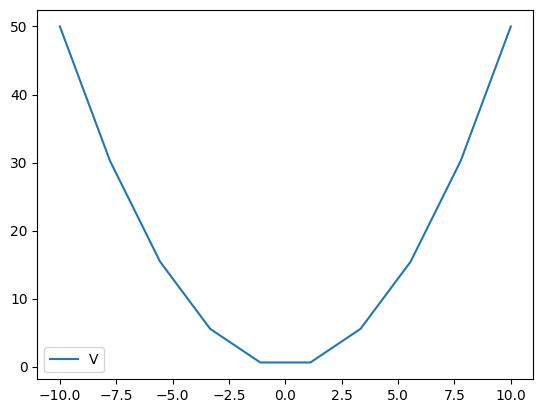

In [9]:
#Defining the potential well
def V(x):
    y = 0.5*x**2
    return y
x = torch.linspace(t0,tf,10).view(-1,1)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, label='V')
#plt.plot(x,scaled_pot, label='V_norm')
plt.legend()
plt.show()

In [10]:
#Defining the Frobenius norm
def frobenius_norm(G):
  I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
  loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
  return loss

#Defining the monotonicity_penalty
def monotonicity_penalty(E, margin = 0.0):
  diffs = E[:-1] - E[1:] + margin
  penalty = torch.relu(diffs).sum()
  return penalty

#Defining the cosine matrix using trapezoidal rule
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x, dim=0)
  return cos_matrix

### The NN Modules

In [11]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = torch.sin #The activation function

    #Defining the Layers
    self.linears = torch.nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    a = x.float()
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [12]:
#Defining group equivariant RqPINN
class equiRqNN(torch.nn.Module):
  def __init__(self,layers):
    super(equiRqNN,self).__init__()
    self.activation = torch.sin #The activation function

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      if i ==len(layers)-2:
        nn.init.zeros_(self.linears[i].bias.data) #Initializing the bias of the last layer to zeros
      else:
        nn.init.normal_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x).float()
    a0 = torch.cat([x,-x], dim=0).view(2,-1,layers[0])
    #Implementing equivariance for l = 1
    z1 = self.linears[0](a0)
    a1 = self.activation(10.0*z1)

    #Implementing equivariance for 1 < l < L-1
    for i in range(1,len(self.linears)-1):
      z21 = self.linears[i](a1[0,:,:] - a1[1,:,:])
      z22 = self.linears[i](a1[1,:,:] - a1[0,:,:])
      z = torch.cat([z21,z22], dim = 0).view(2,-1,layers[i+1])
      a1 = self.activation(10.0*z)

    #Implementing equivariance for l = L
    out = self.linears[-1](a1[0,:,:] - a1[1,:,:])
    return out

### Checkpoint


In [13]:
def save_checkpoint(state, filename):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

#### Learning Rate Finder
We will find the best learning rate to start with

In [14]:
#We want to find the best lr for our defined model
model_lr = qNN(layers).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

In [15]:

def gauss_loss_train_step(NN,t_rand, gm_basis_unsort):
    psi = NN(t_rand) #The forward pass (Not enforcing the boundary because the boundaries of the basis are not same as psi)
    loss = nn.MSELoss()(psi.float(), gm_basis_unsort.float())
    return loss


def common_train_step(NN,t0,tf,xbc,t_rand,t_sort,idx,vx):
    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    # Compute second derivatives
    psi_x = dfx(psi, t_rand)
    psi_xx = dfx(psi_x, t_rand)

    psi_sort = psi[idx,:].to(device); psi_xx_sort = psi_xx[idx,:].to(device)
    
    L,E = hamEqs_Loss(t_sort,psi_sort,psi_xx_sort,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    #We can also add the monotonicty loss
    pde_loss = 3*Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    G = cosine_matrix(psi_sort, t_sort)
    cosine_loss = 100.0*frobenius_norm(G)
    return pde_loss, cosine_loss, E

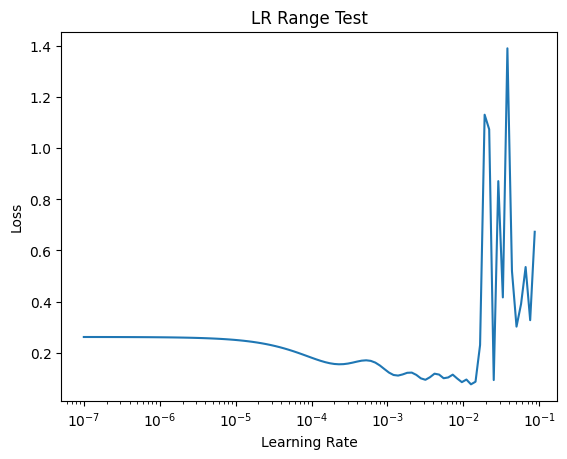

In [16]:
# Set up variables
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
#x_lhs.requires_grad =True
losses = []
lrs = []

#Sorting and unsorting here
# Sort only the coordinates, without gradients
with torch.no_grad():
    t_squeezed = x_lhs.squeeze(-1)
    t_sort, idx = torch.sort(t_squeezed, dim=0)

x_lhs = x_lhs.to(device)
#The Guass Modulated basis set
gm_basis = gauss_modulated_basis(t_sort, eig_num)
gm_basis_lhs = gm_basis[torch.argsort(idx), :].to(device) #To unsort i.e make the index match that of x_lhs

start_lr = 1e-7
end_lr = 1e-1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    #pde_loss,cosine_loss, _ = common_train_step(model_lr,t0,tf,xbc,x_lhs)
    loss = gauss_loss_train_step(model_lr,x_lhs, gm_basis_lhs)
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

It is important to note that the lr finder plot will change with different weights for the losses, so we should update accordingly

#### Training

In [17]:
model = qNN(layers)
model.to(device)
print(model)
#params = list(model.parameters())
#betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=1e-3)

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [18]:
def nn_train(NN,t0,tf,xbc,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #Sorting and unsorting here
  # Sort only the coordinates, without gradients
  t_sort, idx = torch.sort(t.squeeze(-1), dim=0)
  t_rand = t.to(device).requires_grad_(True).float()

  #Obtaining the potential
  vx = V(t_sort.unsqueeze(1)).to(device)

  #The Guass Modulated basis set
  gm_basis = gauss_modulated_basis(t_sort, eig_num)
  gm_basis_lhs = gm_basis[torch.argsort(idx), :].to(device) #To unsort i.e make the index match that of x_lhs

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(train_epochs + pre_trainer_epoch + 1):
    optimizer.zero_grad()

    if iter < pre_trainer_epoch:
      total_loss = gauss_loss_train_step(NN,t_rand, gm_basis_lhs)
      if iter % 2000 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print('Total_loss: ',total_loss.item())

      #For visualization after training
      if iter == pre_trainer_epoch-1:
        checkpoint = {"psi_state_dict": NN.state_dict()}
        save_checkpoint(checkpoint, "checkpoints/pretrainer_using_gauss_mod_basis.pth")
    
    else:
      criteria_loss,cosine_loss,En = common_train_step(NN,t0,tf,xbc,t_rand,t_sort.to(device),idx,vx)
      total_loss = criteria_loss + cosine_loss
    
      En_history.append(En.cpu().detach().numpy())
    
      loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())

      loss_dic['cos_loss_hist'].append(cosine_loss.cpu().detach().numpy().item())


      if iter % 200 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
        print('pde_loss: ',criteria_loss.item())
        print('cos_loss: ',cosine_loss.item())
      

    #Backward propagation
    total_loss.backward()
    optimizer.step()

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [19]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([200, 1])

In [20]:
Loss, eig_vals, qPINN = nn_train(model,t0,tf,xbc, x_lhs)

--------------------------------------------
Epoch: 0
Total_loss:  0.8578391671180725
--------------------------------------------
Epoch: 2000
Total_loss:  9.520471940049902e-05
--------------------------------------------
Epoch: 4000
Total_loss:  9.918083378579468e-06
--------------------------------------------
Epoch: 6000
Total_loss:  1.7947895685210824e-05
--------------------------------------------
Epoch: 8000
Total_loss:  3.4312754451093497e-06
--------------------------------------------
Epoch: 10000
Total_loss:  9.300422334490577e-07
--------------------------------------------
Epoch: 12000
Total_loss:  6.323353591142222e-05
--------------------------------------------
Epoch: 14000
Total_loss:  8.923185305320658e-06
Saving checkpoint
--------------------------------------------
Epoch: 15000
En: [0.62424   1.8734659 5.8150907]
--------------------------------------------
Total_loss:  12.795705795288086
pde_loss:  3.1363115310668945
cos_loss:  9.659394264221191
-----------------

In [21]:
tTest = torch.linspace(t0,tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_42664\3215202776.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


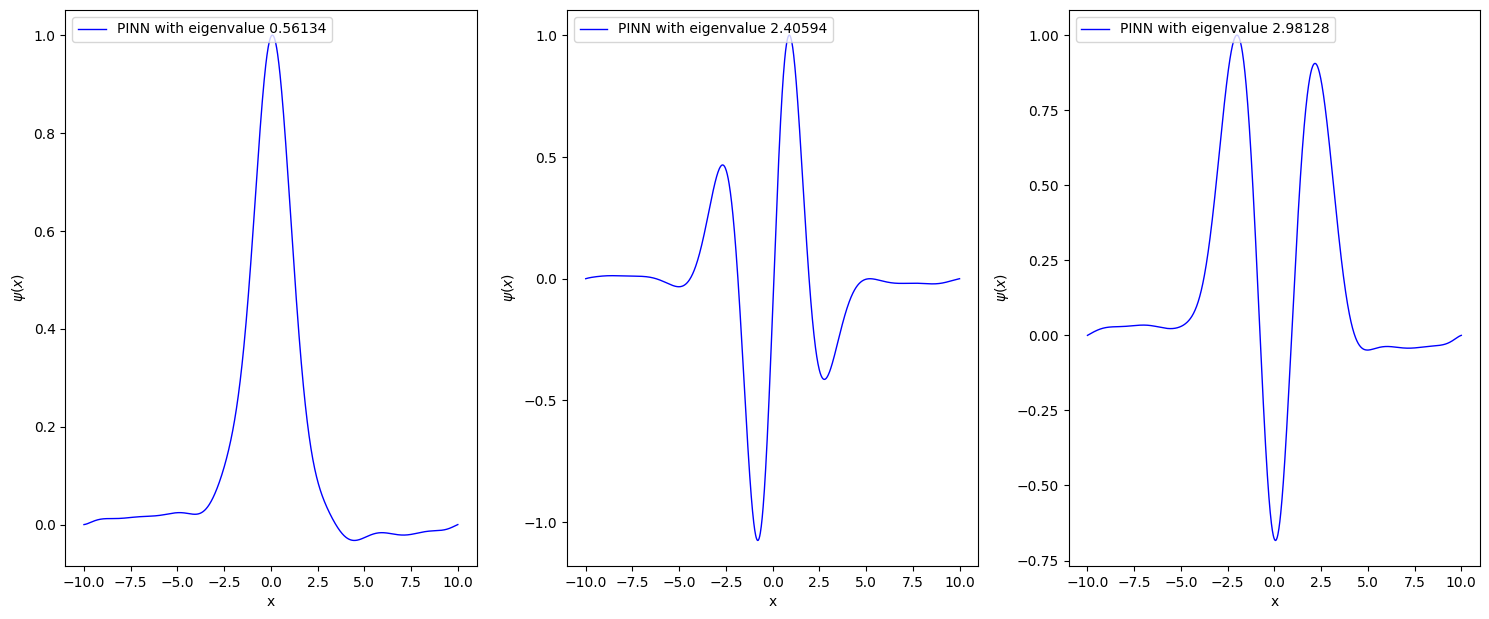

In [22]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    max_val = abs(max(psi[:,index]))
    ax.plot(t_net, psi[:,index]/max_val, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

In [23]:
#pre_trainer test
gauss_pretrainer = qNN(layers)
#The checkpoint
checkpoint = torch.load('checkpoints/pretrainer_using_gauss_mod_basis.pth',map_location=torch.device('cuda'))
gauss_pretrainer.load_state_dict(checkpoint['psi_state_dict'])
gauss_pretrainer.to(device)

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_42664\2447874202.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$\psi$_{i}")


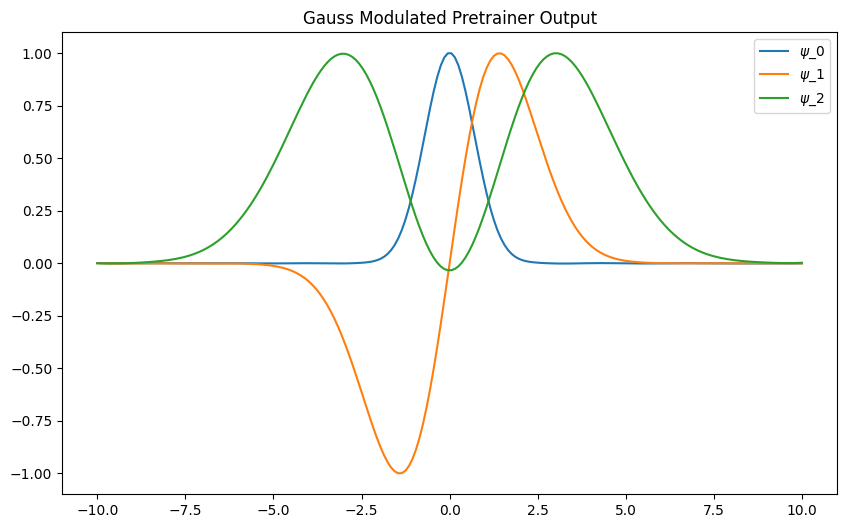

In [24]:
gauss_pretrainer.eval()
t_test = torch.linspace(t0,tf, col_pts).view(-1,1) #For plotting
with torch.no_grad():
    t = t_test.to(device)
    psi_hat = gauss_pretrainer(t)

    plt.figure(figsize=(10,6))
    for i in range(eig_num):
        plt.plot(t.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$\psi$_{i}")
    plt.title("Gauss Modulated Pretrainer Output")
    plt.legend()
    plt.show()

In [25]:
G = psi.T @ psi
G

array([[ 1.85611252e+02, -9.85089064e-01,  1.35142222e-01],
       [-9.85089064e-01,  6.66703796e+01, -4.84676749e-01],
       [ 1.35142222e-01, -4.84676749e-01,  1.01757805e+02]], dtype=float32)

## Using a guassian pretrainer with random means and variances 

IndexError: index 3 is out of bounds for dimension 1 with size 3

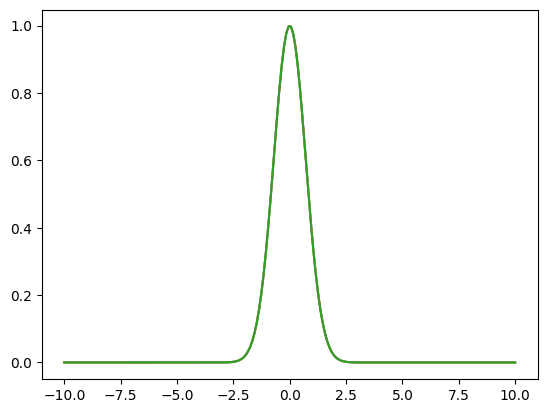

In [26]:
#The gaussian function
def gaussian(t):
    gaussians = [torch.exp(-((t)**2)) for _ in range(eig_num)]
    return torch.cat(gaussians, dim=1)  # shape (n, k)

t_test = torch.linspace(t0,tf, col_pts).view(-1,1) #For plotting
#Note: Shift the means accordings to your potential
#mus = torch.tensor(-5 + (5 + 5)*lhs(1,eig_num)).view(-1,1) #Random means between [-5,5]
#sigmas = torch.tensor(0.5 + (1.0 - 0.5)*lhs(1,eig_num)).view(-1,1) #Random std's between [0.5,1.0]
target = gaussian(t_test)

for i in range(5):
    plt.plot(t_test, target[:,i])
plt.show()
target.shape

#### Lr Finder

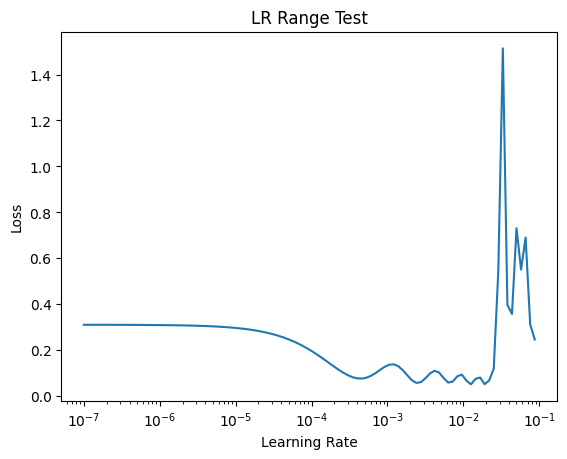

In [ ]:
#We want to find the best lr for our defined model
model_lr = qNN(layers).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)


# Set up variables
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
#x_lhs.requires_grad =True
losses = []
lrs = []

#Sorting and unsorting here
# Sort only the coordinates, without gradients
with torch.no_grad():
    t_squeezed = x_lhs.squeeze(-1)
    t_sort, idx = torch.sort(t_squeezed, dim=0)

x_lhs = x_lhs.to(device)
#The Guass Modulated basis set
gm_basis = gaussian(t_sort.unsqueeze(1))
gm_basis_lhs = gm_basis[torch.argsort(idx), :].to(device) #To unsort i.e make the index match that of x_lhs

start_lr = 1e-7
end_lr = 1e-1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    #pde_loss,cosine_loss, _ = common_train_step(model_lr,t0,tf,xbc,x_lhs)
    loss = gauss_loss_train_step(model_lr,x_lhs, gm_basis_lhs)
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

### Training

In [ ]:
model = qNN(layers)
model.to(device)
print(model)
#params = list(model.parameters())
#betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=1e-4)

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)


In [ ]:
def nn_train(NN,t0,tf,xbc,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #Sorting and unsorting here
  # Sort only the coordinates, without gradients
  t_sort, idx = torch.sort(t.squeeze(-1), dim=0)
  t_rand = t.to(device).requires_grad_(True).float()

  #Obtaining the potential
  vx = V(t_sort.unsqueeze(1)).to(device)

  #The Guass Modulated basis set
  gm_basis = gaussian(t_sort.unsqueeze(1))
  gm_basis_lhs = gm_basis[torch.argsort(idx), :].to(device) #To unsort i.e make the index match that of x_lhs

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(pre_trainer_epoch + train_epochs + 1):
    optimizer.zero_grad()

    if iter < pre_trainer_epoch:
      total_loss = gauss_loss_train_step(NN,t_rand, gm_basis_lhs)
      if iter % (pre_trainer_epoch//4) == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print('Total_loss: ',total_loss.item())

      #For visualization after training
      if iter == pre_trainer_epoch-1:
        checkpoint = {"psi_state_dict": NN.state_dict()}
        save_checkpoint(checkpoint, "checkpoints/pretrainer_using_with_no_shifted_gauss.pth")
    
    else:
      criteria_loss,cosine_loss,En = common_train_step(NN,t0,tf,xbc,t_rand,t_sort.to(device),idx,vx)
      total_loss = criteria_loss + cosine_loss
    
      En_history.append(En.cpu().detach().numpy())
    
      loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())

      loss_dic['cos_loss_hist'].append(cosine_loss.cpu().detach().numpy().item())


      if iter % 200 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.item())
        print('pde_loss: ',criteria_loss.item())
        print('cos_loss: ',cosine_loss.item())
      

    #Backward propagation
    total_loss.backward()
    optimizer.step()

    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())

  #Storing the final eigenfunction
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [ ]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
Loss, eig_vals, qPINN = nn_train(model,t0,tf,xbc,x_lhs)

--------------------------------------------
Epoch: 0
Total_loss:  0.43540462851524353
--------------------------------------------
Epoch: 3750
Total_loss:  0.00019830836390610784
--------------------------------------------
Epoch: 7500
Total_loss:  7.929413186502643e-06
--------------------------------------------
Epoch: 11250
Total_loss:  2.34679146160488e-06
Saving checkpoint
--------------------------------------------
Epoch: 15000
En: [0.62644494 0.62656826 0.6264855  0.62602323 0.6259642 ]
--------------------------------------------
Total_loss:  447.55596923828125
pde_loss:  0.344086229801178
cos_loss:  447.2118835449219
--------------------------------------------
Epoch: 15200
En: [14.651368  10.054657  27.046228   3.3756824  4.2049255]
--------------------------------------------
Total_loss:  18.89821434020996
pde_loss:  13.563682556152344
cos_loss:  5.334531784057617
--------------------------------------------
Epoch: 15400
En: [14.530018   8.574838  28.127293   2.811125   3.

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_43608\1649321716.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$\psi$_{i}")


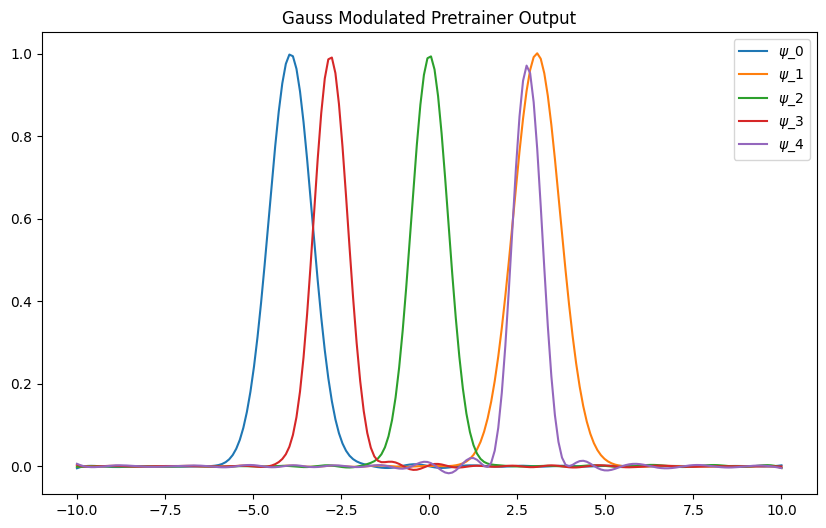

In [ ]:
#pre_trainer test
gauss_pretrainer = qNN(layers)
#The checkpoint
checkpoint = torch.load('checkpoints/pretrainer_using_shifted_gauss.pth',map_location=torch.device('cuda'))
gauss_pretrainer.load_state_dict(checkpoint['psi_state_dict'])
gauss_pretrainer.to(device)


gauss_pretrainer.eval()
t_test = torch.linspace(t0,tf, col_pts).view(-1,1) #For plotting
with torch.no_grad():
    t = t_test.to(device)
    psi_hat = gauss_pretrainer(t)

    plt.figure(figsize=(10,6))
    for i in range(eig_num):
        plt.plot(t.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$\psi$_{i}")
    plt.title("Gauss Modulated Pretrainer Output")
    plt.legend()
    plt.show()

In [ ]:
tTest = torch.linspace(t0,tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_43608\3215202776.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


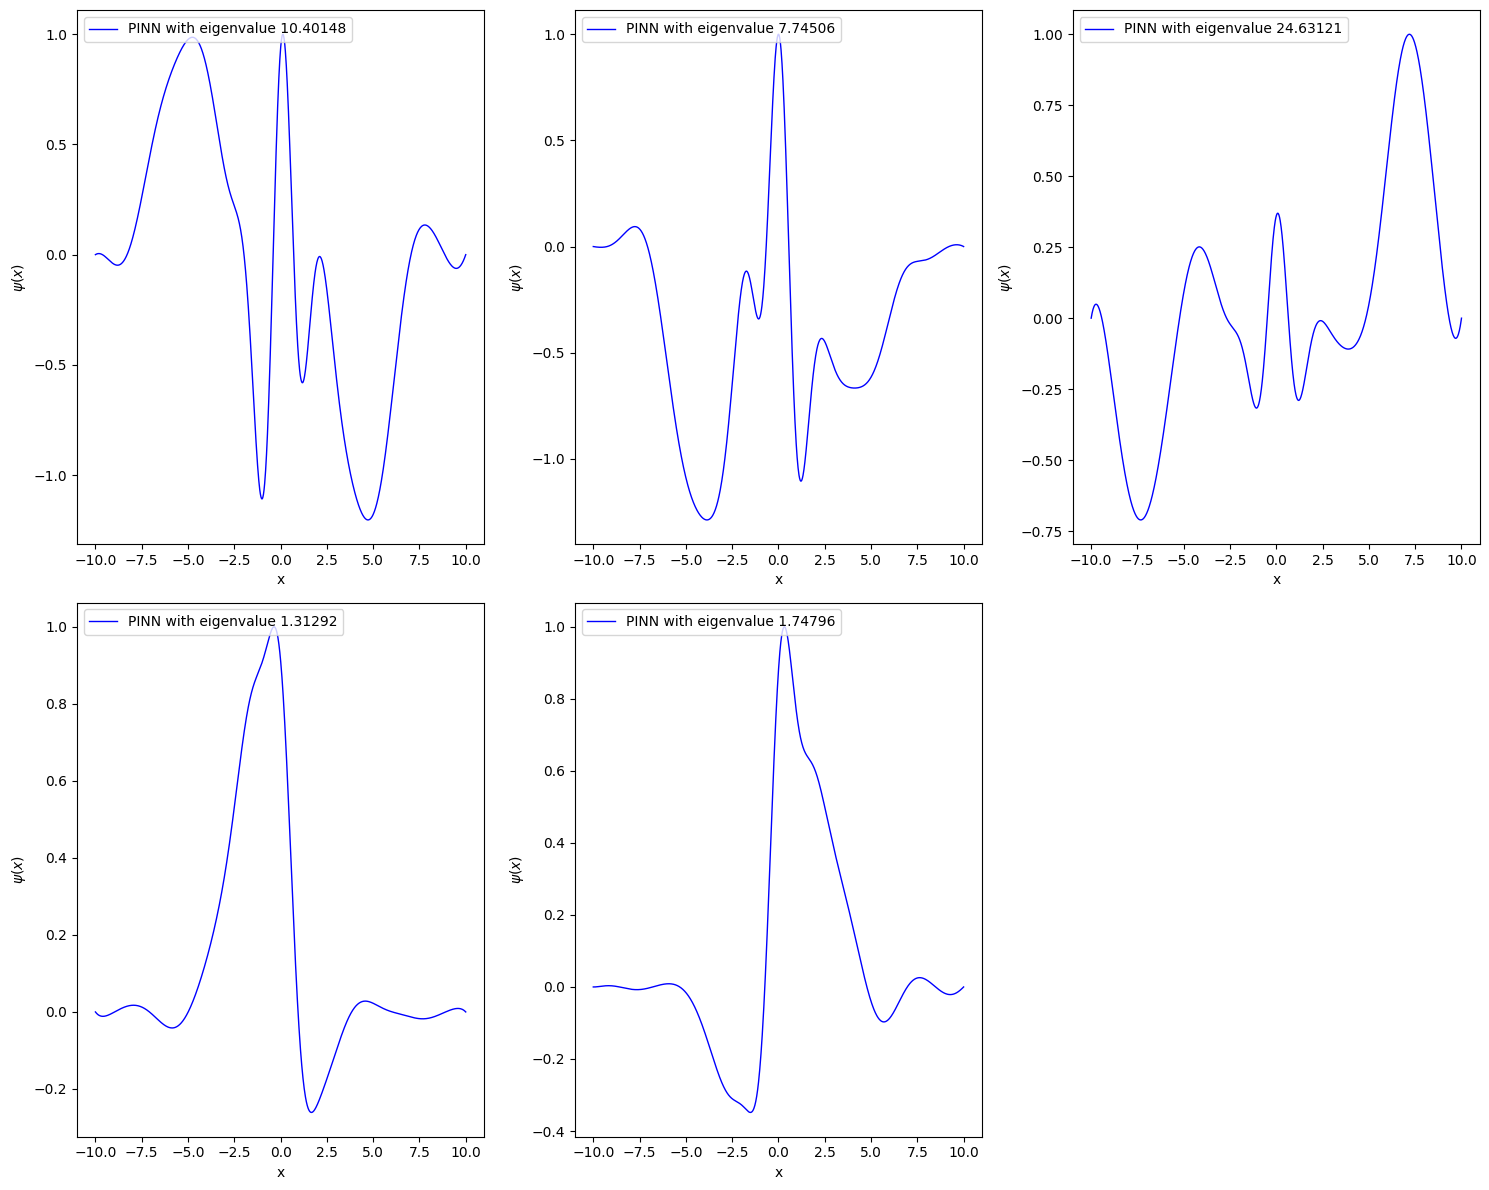

In [ ]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    max_val = abs(max(psi[:,index]))
    ax.plot(t_net, psi[:,index]/max_val, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

#### Including Symmetry with Gaussian

In [ ]:
model_sym = qNN(layers)
model_sym.to(device)
print(model_sym)
#params = list(model_sym.parameters())
#betas = [0.999, 0.9999]
optimizer_sym = optim.Adam(model_sym.parameters(), lr=1e-4)

qNN(
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=5, bias=True)
  )
)
